In [113]:
import os
from scipy.stats.contingency import odds_ratio
from scipy import stats
import forestplot as fp
from scipy.stats import fisher_exact, ttest_ind
import pandas as pd

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
import seaborn as sns

import sys

sys.path.append("../src/utils")

import parsing as utpa

import os
import pandas as pd
from functools import reduce
from itertools import combinations

import upsetplot
import seaborn as sns
from matplotlib.ticker import MultipleLocator
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
matplotlib.rcParams['font.sans-serif'] = "Arial" # missing fonts:: https://alexanderlabwhoi.github.io/post/2021-03-missingfont/
# Then, "ALWAYS use sans-serif fonts"
matplotlib.rcParams['font.family'] = "sans-serif"
matplotlib.rcParams.update({'font.size': 14, 'axes.linewidth': 2, 'xtick.major.width': 1.5, 'xtick.major.size': 7, 'ytick.major.width': 1.5, 'ytick.major.size': 7})
from matplotlib.backends.backend_pdf import PdfPages

In [114]:
# combo information files
obese_case_cont_file = "/data6/deepro/ukb_bmi/1_data_processing/data/british/case_controls.csv"
combo_info_dir = "/data6/deepro/ukb_bmi/3_characterization/data/combo_info/comorbidities"
comorbidities = ["E03.9Hypothyroidism,unspecified", "E11Non-insulin-dependentdiabetesmellitus", "E78.0Purehypercholesterolaemia", "I10Essential(primary)hypertension", "I20-I25Ischaemicheartdiseases", "K80-K87Disordersofgallbladder,biliarytractandpancreas", "M15-M19Arthrosis"]
comorbidity_codes = ["E039", "E11", "E780", "I10", "BlockI20-I25", "BlockK80-K87", "BlockM15-M19"]
combo_info_filename_start = "discovery"
combo_dir = "/data6/deepro/ukb_bmi/2_rarecomb/data"
group_names = ["british", "comorbidities/E03.9Hypothyroidism,unspecified", "comorbidities/E11Non-insulin-dependentdiabetesmellitus", "comorbidities/E78.0Purehypercholesterolaemia", "comorbidities/I10Essential(primary)hypertension", "comorbidities/I20-I25Ischaemicheartdiseases", "comorbidities/K80-K87Disordersofgallbladder,biliarytractandpancreas", "comorbidities/M15-M19Arthrosis"] # "protective"

# phenotype information files
phenotype_file = "/data6/deepro/ukb_bmi/0_data_preparation_and_download/phenotype/data/bmi_processed/british/train_cohort_bmi.csv.gz"
prs_obesity_related_file = "/data6/deepro/ukb_bmi/0_data_preparation_and_download/obesity_related_prs/data/prs_processed/obesity_related.csv.gz"

# icd information files
icd_raw_dir = "/data6/deepro/ukb_bmi/0_data_preparation_and_download/icd_codes/data/icd_raw"
icd_codes_file = "/data6/deepro/ukb_bmi/0_data_preparation_and_download/icd_codes/data/icd_tree/coding19.tsv"
cohort_file = "/data6/deepro/ukb_bmi/0_data_preparation_and_download/phenotype/data/bmi_processed/british/train_cohort_bmi.csv.gz"
hes_info_file = "/data6/deepro/ukb_bmi/0_data_preparation_and_download/icd_codes/data/hes_info/hes_info.csv.gz"

In [115]:
def get_combo_set(combo_dir, group):
    combo2_file = os.path.join(combo_dir, group, "combo2.csv")
    combo3_file = os.path.join(combo_dir, group, "combo3.csv")
    try:
        combo2_df = pd.read_csv(combo2_file, usecols=["uniq_items"])
        combo2_set = set(combo2_df.uniq_items.to_list())
    except FileNotFoundError:
        combo2_set = set()
    try:
        combo3_df = pd.read_csv(combo3_file, usecols=["uniq_items"])
        combo3_set = set(combo3_df.uniq_items.to_list())
    except FileNotFoundError:
        combo3_set =set()
    combo_set = combo2_set.union(combo3_set)
    return combo_set

def set_add(a, b):
    return a.intersection(b)

def set_subtract(a,b):
    return a.difference(b)

def get_intersects(include_sets, exclude_sets):
    intersect_sets = reduce(set_add, include_sets)
    if len(exclude_sets)>0:
        exclude_sets = [intersect_sets] + exclude_sets
        intersect_sets = reduce(set_subtract, exclude_sets)
    return intersect_sets

def get_upset_df(combo_dir, groups):
    # get the set of gene combinations for each group
    combo_dict = {g: get_combo_set(combo_dir, g) for g in groups}
    combo_boolean_dict = {g:[] for g in groups}
    counts = []
    unique_intersect_sets = dict()
    for i in range(1, len(groups) + 1):
        # get combinations of length i
        all_combos = list(combinations(groups, i))
        for combos in all_combos:
            # get counts of elements that are unique to the combinations
            include_combos = combos
            exclude_combos = tuple(g for g in groups if g not in include_combos)
            include_sets = [combo_dict[c] for c in include_combos]
            exclude_sets = [combo_dict[c] for c in exclude_combos]
            unique_intersects = get_intersects(include_sets, exclude_sets)
            counts.append(len(unique_intersects))
            unique_intersect_sets[(include_combos, exclude_combos)] = unique_intersects
            for c in include_combos:
                combo_boolean_dict[c].append(True)
            for c in exclude_combos:
                combo_boolean_dict[c].append(False)
    combo_boolean_dict["counts"] = counts
    df = pd.DataFrame(combo_boolean_dict)
    return df.set_index(groups), unique_intersect_sets

In [116]:
upset_df, unique_intersects = get_upset_df(combo_dir, group_names)

In [117]:
parsed_upset_df = upset_df.loc[upset_df.counts>0]

# Annotate obese info

In [3]:
def get_scaled_bmi(df, categorical_cols, numerical_cols, scaled_numerical_cols):
    # define encoders
    en = LabelEncoder()
    scaler = StandardScaler()
    # select the categorical and numerical columns
    # transform the categorical columns to integer values
    for cat_col in categorical_cols:
        df[cat_col] = en.fit_transform(df[cat_col])
    # scale the numerical columns
    df[numerical_cols] = scaler.fit_transform(df.loc[:, numerical_cols])
    # scale bmi separately
    df["bmi_scaled"] = scaler.fit_transform(df.loc[:, ["bmi"]])
    # Create the target variable (bmi_residuals) using linear regression
    X = df.loc[:, categorical_cols + numerical_cols + scaled_numerical_cols]
    y = df.loc[:, 'bmi_scaled']
    model = LinearRegression()
    model.fit(X, y)
    # save the residuals for bmi
    df['bmi_residuals'] = y - model.predict(X)
    return df

def create_bmi_res_prs_decile_data(phenotype_df):
    categorical_cols = ["genetic_sex"]
    numerical_cols = ["age"] + [f"genetic_pca{i}" for i in range(1, 40)]
    scaled_numerical_cols = []#["bmi_prs"]

    phenotype_df = get_scaled_bmi(phenotype_df, categorical_cols, numerical_cols, scaled_numerical_cols)
    phenotype_df["bmi_res_decile"] = pd.qcut(phenotype_df.bmi_residuals, q=10)
    phenotype_df["bmi_res_decile_num"] = pd.qcut(phenotype_df.bmi_residuals, q=10, labels=False)
    phenotype_df["bmi_prs_decile"] = pd.qcut(phenotype_df.bmi_prs, q=10)
    phenotype_df["bmi_prs_decile_num"] = pd.qcut(phenotype_df.bmi_prs, q=10, labels=False)
    phenotype_df["bmi_res_categories"] = phenotype_df.bmi_res_decile_num.map({
        0: "underweight", 
        1:"normal", 2:"normal", 
        3:"overweight", 4:"overweight", 5:"overweight", 6:"overweight", 7:"overweight",
        8:"obese", 9:"severe obesity"
        })
    phenotype_df["bmi_prs_categories"] = phenotype_df.bmi_prs_decile_num.map({
        0: "lowest", 
        1:"middle", 2:"middle", 
        3:"middle", 4:"middle", 5:"middle", 6:"middle", 7:"middle",
        8:"middle", 9:"highest"
        })
    mean_bmi_dict = phenotype_df.groupby("bmi_res_categories")["bmi"].mean().to_dict()
    return phenotype_df, mean_bmi_dict

def get_all_combo_info(combo_info_dir, comorbidities, comorbidity_codes, combo_info_filename_start):
    combo_dfs = []
    for cm, cmc in zip(comorbidities, comorbidity_codes):
        combo_df = pd.concat([pd.read_csv(cf) for cf in os.scandir(os.path.join(combo_info_dir, cm)) if (cf.name.startswith(combo_info_filename_start)&(cf.name.endswith(".csv")))])
        combo_df["combo_samples"] = combo_df.combo_samples.str.split("|")
        combo_df = combo_df.explode("combo_samples")
        combo_df = combo_df.reset_index(drop=True)
        combo_df["disease"] = cm
        combo_df["code"] = cmc
        combo_dfs.append(combo_df)

    all_combo_df = pd.concat(combo_dfs).reset_index(drop=True)
    return all_combo_df

# Get phenotype info

In [4]:
phenotype_df = pd.read_csv(
        phenotype_file, 
        usecols=["sample_names", "genetic_sex", "age"] + [f"genetic_pca{i}" for i in range(1, 40)] + ["bmi_prs", "bmi"])
phenotype_df["sample_names"] = phenotype_df.sample_names.astype(str)
phenotype_samples_df, mean_bmi_dict = create_bmi_res_prs_decile_data(phenotype_df)

prs_obesity_related_df = pd.read_csv(prs_obesity_related_file, dtype={"sample_names": str, "ht_prs":float, "t2d_prs":float})
phenotype_w_prs_df = phenotype_samples_df.merge(prs_obesity_related_df, left_on="sample_names", right_on="sample_names")

# Get combo info

In [5]:
all_combo_df = get_all_combo_info(combo_info_dir, comorbidities, comorbidity_codes, combo_info_filename_start)

# Add obesity info to all combo info

In [16]:
all_combo_info_df = all_combo_df.merge(phenotype_w_prs_df.loc[:, ["sample_names", "bmi_res_categories", "bmi_prs_categories"]], left_on="combo_samples", right_on="sample_names")

# ICD annotation

In [20]:
icd_samples_df = utpa.create_icd_samples_file(icd_raw_dir)
icd_codes_df = pd.read_csv(icd_codes_file, usecols=["coding", "meaning", "node_id", "parent_id"], sep="\t")
icd_codes_df["coding"] = icd_codes_df.coding.str.replace(" ", "")
pheno_tree, root_pheno, c2nodeid_dict = utpa.create_tree(icd_codes_df, icd_samples_df)
hes_info_df = pd.read_csv(hes_info_file, dtype={"sample_names": str, "hes_info": float})
all_icd_samples = set(hes_info_df.loc[hes_info_df.hes_info>0, "sample_names"].values)

In [23]:
all_combo_w_icd_df = all_combo_info_df.loc[all_combo_info_df.combo_samples.isin(all_icd_samples)]

In [24]:
all_combo_w_icd_obese_df = all_combo_w_icd_df.loc[(all_combo_w_icd_df.bmi_res_categories=="obese")|(all_combo_w_icd_df.bmi_res_categories=="severe obesity")]

In [25]:
all_combo_w_icd_nonobese_df = all_combo_w_icd_df.loc[(all_combo_w_icd_df.bmi_res_categories!="obese")&(all_combo_w_icd_df.bmi_res_categories!="severe obesity")]

In [26]:
def get_table_icd(combo_samples, noncombo_samples, comorbid_samples, field):
    table = [
        [len(combo_samples.intersection(comorbid_samples)), len(combo_samples.difference(comorbid_samples))],
        [len(noncombo_samples.intersection(comorbid_samples)), len(noncombo_samples.difference(comorbid_samples))]
    ]
    df = pd.DataFrame(table, columns=[f"{field}", f"No {field}"], index=["Combo", "Non Combo"])
    return df

In [27]:
def check_icd_enrichment_combo_in_groups(all_combo_w_icd_df, all_samples):
    all_combo_w_icd_dfs = []
    icd_data = []

    for group, gdf in all_combo_w_icd_df.groupby("code"):
        icdc_node = pheno_tree.node_dict[c2nodeid_dict[group]]
        icd_samples = icdc_node.get_samples()
        gdf["icd_case"] = gdf.combo_samples.isin(icd_samples)
        combo_samples = set(gdf.combo_samples.unique())
        non_combo_samples = all_samples.difference(combo_samples)
        df = get_table_icd(combo_samples, non_combo_samples, icd_samples, group)
        res = fisher_exact(df)
        or_study = odds_ratio(df)
        cil, cih = or_study.confidence_interval(confidence_level=0.95)
        icdc_node_data = (group, icdc_node.meaning, df.iloc[0,0], df.iloc[0,1], df.iloc[1,0], df.iloc[1,1], or_study.statistic, res.pvalue, cil, cih)
        icd_data.append(icdc_node_data)
        all_combo_w_icd_dfs.append(gdf)

    all_combo_w_icd_annot_df = pd.concat(all_combo_w_icd_dfs)
    all_combo_w_icd_enrich_df = pd.DataFrame(icd_data, columns=["icd_code", "icd_meaning", "combo_comorbid", "combo_noncomorbid", "noncombo_comorbid", "noncombo_noncomorbid", "odds_ratio", "p_value", "ci_low", "ci_high"])
    return all_combo_w_icd_annot_df, all_combo_w_icd_enrich_df

In [29]:
obese_samples = set(phenotype_w_prs_df.loc[(phenotype_w_prs_df.bmi_res_categories=="obese")|(phenotype_w_prs_df.bmi_res_categories=="severe obesity"), "sample_names"].astype(str).values)
non_obese_samples = all_icd_samples.difference(obese_samples)

In [30]:
all_combo_w_icd_annot_nonobese_df, all_combo_w_icd_enrich_nonobese_df = check_icd_enrichment_combo_in_groups(all_combo_w_icd_nonobese_df, non_obese_samples)

In [31]:
all_combo_w_icd_annot_obese_df, all_combo_w_icd_enrich_obese_df = check_icd_enrichment_combo_in_groups(all_combo_w_icd_obese_df, obese_samples)

In [32]:
all_combo_w_icd_annot_df, all_combo_w_icd_enrich_df = check_icd_enrichment_combo_in_groups(all_combo_w_icd_df, all_icd_samples)

In [33]:
all_combo_w_icd_enrich_df

,icd_code,icd_meaning,combo_comorbid,combo_noncomorbid,noncombo_comorbid,noncombo_noncomorbid,odds_ratio,p_value,ci_low,ci_high
0,BlockI20-I25,I20-I25 Ischaemic heart diseases,5222,4808,52144,386916,8.059000,0.0,7.739677,8.391632
1,BlockK80-K87,"K80-K87 Disorders of gallbladder, biliary trac...",6442,12535,28292,401821,7.298969,0.0,7.065283,7.539944
2,BlockM15-M19,M15-M19 Arthrosis,5888,2606,87130,353466,9.165799,0.0,8.745944,9.607755
3,E039,"E03.9 Hypothyroidism, unspecified",7572,20947,21479,399092,6.716517,0.0,6.519366,6.919253
4,E11,E11 Non-insulin-dependent diabetes mellitus,7782,15463,33057,392788,5.979834,0.0,5.805425,6.159182
5,E780,E78.0 Pure hypercholesterolaemia,6637,5082,64351,373020,7.570260,0.0,7.290608,7.860977
6,I10,I10 Essential (primary) hypertension,10386,2053,140589,296062,10.653404,0.0,10.155401,11.179996


In [20]:
all_combo_w_icd_enrich_df

,icd_code,icd_meaning,combo_comorbid,combo_noncomorbid,noncombo_comorbid,noncombo_noncomorbid,odds_ratio,p_value,ci_low,ci_high
0,BlockI20-I25,I20-I25 Ischaemic heart diseases,5222,4808,52144,386916,8.059000,0.0,7.739677,8.391632
1,BlockK80-K87,"K80-K87 Disorders of gallbladder, biliary trac...",6442,12535,28292,401821,7.298969,0.0,7.065283,7.539944
2,BlockM15-M19,M15-M19 Arthrosis,5888,2606,87130,353466,9.165799,0.0,8.745944,9.607755
3,E039,"E03.9 Hypothyroidism, unspecified",7572,20947,21479,399092,6.716517,0.0,6.519366,6.919253
4,E11,E11 Non-insulin-dependent diabetes mellitus,7782,15463,33057,392788,5.979834,0.0,5.805425,6.159182
5,E780,E78.0 Pure hypercholesterolaemia,6637,5082,64351,373020,7.570260,0.0,7.290608,7.860977
6,I10,I10 Essential (primary) hypertension,10386,2053,140589,296062,10.653404,0.0,10.155401,11.179996


In [34]:
all_combo_w_icd_enrich_obese_df

,icd_code,icd_meaning,combo_comorbid,combo_noncomorbid,noncombo_comorbid,noncombo_noncomorbid,odds_ratio,p_value,ci_low,ci_high
0,BlockI20-I25,I20-I25 Ischaemic heart diseases,1550,992,12453,70515,8.847279,0.0,8.145531,9.612777
1,BlockK80-K87,"K80-K87 Disorders of gallbladder, biliary trac...",2140,2479,8058,72833,7.802241,0.0,7.327582,8.307322
2,BlockM15-M19,M15-M19 Arthrosis,1790,481,23307,59932,9.569021,0.0,8.637652,10.616564
3,E039,"E03.9 Hypothyroidism, unspecified",2310,4301,5343,73556,7.393611,0.0,6.975794,7.835584
4,E11,E11 Non-insulin-dependent diabetes mellitus,3865,2769,12048,66828,7.742019,0.0,7.343676,8.162746
5,E780,E78.0 Pure hypercholesterolaemia,1993,947,15303,67267,9.250527,0.0,8.540331,10.025019
6,I10,I10 Essential (primary) hypertension,3326,303,36558,45323,13.608363,0.0,12.084535,15.370044


In [35]:
all_combo_w_icd_enrich_nonobese_df

,icd_code,icd_meaning,combo_comorbid,combo_noncomorbid,noncombo_comorbid,noncombo_noncomorbid,odds_ratio,p_value,ci_low,ci_high
0,BlockI20-I25,I20-I25 Ischaemic heart diseases,3672,3816,39691,322409,7.816368,0.0,7.459155,8.190618
1,BlockK80-K87,"K80-K87 Disorders of gallbladder, biliary trac...",4302,10056,20234,334996,7.082690,0.0,6.814053,7.361146
2,BlockM15-M19,M15-M19 Arthrosis,4098,2125,63823,299542,9.050856,0.0,8.580682,9.548847
3,E039,"E03.9 Hypothyroidism, unspecified",5262,16646,16136,331544,6.495041,0.0,6.271691,6.725755
4,E11,E11 Non-insulin-dependent diabetes mellitus,3917,12694,21009,331968,4.875763,0.0,4.690652,5.067457
5,E780,E78.0 Pure hypercholesterolaemia,4644,4135,49048,311761,7.138605,0.0,6.836765,7.453959
6,I10,I10 Essential (primary) hypertension,7060,1750,104031,256747,9.956491,0.0,9.442638,10.502620


# Specific combinations causing comorbidity only in the presence of obesity

1. Fishers exact, comorbid enriched significantly amongst obese individuals compared to non-obese

In [37]:
all_combo_w_icd_annot_df

,uniq_items,combo_samples,disease,code,sample_names,bmi_res_categories,bmi_prs_categories,icd_case
108,Input_HTT|Input_VPS13B,4150653,I20-I25Ischaemicheartdiseases,BlockI20-I25,4150653,underweight,middle,False
132,Input_REM1|Input_SLFN11,4686010,I20-I25Ischaemicheartdiseases,BlockI20-I25,4686010,overweight,middle,False
195,Input_FOXO3|Input_KRT71,2731575,I20-I25Ischaemicheartdiseases,BlockI20-I25,2731575,overweight,middle,True
222,Input_FOXO3|Input_KRT71,5153210,I20-I25Ischaemicheartdiseases,BlockI20-I25,5153210,underweight,middle,False
309,Input_HKDC1|Input_MUC12,3022728,I20-I25Ischaemicheartdiseases,BlockI20-I25,3022728,overweight,middle,False
...,...,...,...,...,...,...,...,...
102041,Input_AARS2|Input_MYH11|Input_TMEM151B,3558508,I10Essential(primary)hypertension,I10,3558508,overweight,middle,True
102042,Input_AARS2|Input_MYH11|Input_TMEM151B,4101695,I10Essential(primary)hypertension,I10,4101695,overweight,middle,True
102043,Input_LRP4|Input_PSMD10|Input_TEX13A,3503851,I10Essential(primary)hypertension,I10,3503851,obese,middle,True
102044,Input_LRP4|Input_PSMD10|Input_TEX13A,4912795,I10Essential(primary)hypertension,I10,4912795,underweight,middle,True


In [60]:
def get_table_icd(obese_samples, nonobese_samples, comorbid_samples, field):
    table = [
        [len(obese_samples.intersection(comorbid_samples)), len(obese_samples.difference(comorbid_samples))],
        [len(nonobese_samples.intersection(comorbid_samples)), len(nonobese_samples.difference(comorbid_samples))]
    ]
    df = pd.DataFrame(table, index=["Obese", "Non obese"], columns=[f"{field}", f"No {field}"])
    return df

In [65]:

combo_obesity_data = []

for disease_combo, disease_combo_df in all_combo_w_icd_annot_df.groupby(["disease", "uniq_items"]):
    disease = disease_combo[0]
    combo = disease_combo[1]
    case_samples = set(disease_combo_df.loc[disease_combo_df.icd_case==True, "sample_names"].values)
    obese_samples = set(disease_combo_df.loc[(disease_combo_df.bmi_res_categories=="obese")|(disease_combo_df.bmi_res_categories=="severe obesity"), "sample_names"].values)
    nonobese_samples = set(disease_combo_df.loc[(disease_combo_df.bmi_res_categories!="obese")&(disease_combo_df.bmi_res_categories!="severe obesity"), "sample_names"].values)
    df = get_table_icd(obese_samples, nonobese_samples, case_samples, disease)
    res = fisher_exact(df)
    or_study = odds_ratio(df)
    cil, cih = or_study.confidence_interval(confidence_level=0.95)
    combo_data = (disease, combo, df.iloc[0,0], df.iloc[0,1], df.iloc[1,0], df.iloc[1,1], or_study.statistic, res.pvalue, cil, cih)
    combo_obesity_data.append(combo_data)

combo_obesity_df = pd.DataFrame(combo_obesity_data, columns=["disease", "combo", "obese_comorbid", "obese_noncomorbid", "nonobese_comorbid", "nonobese_noncomorbid", "odds_ratio", "p_value", "ci_low", "ci_high"])
combo_obesity_df["FDR"] = stats.false_discovery_control(combo_obesity_df.p_value)

In [68]:
len(combo_obesity_df.loc[combo_obesity_df.odds_ratio<1])/len(combo_obesity_df)

0.19633978631122395

In [84]:
all_combo_df.drop_duplicates(["disease"])

,uniq_items,combo_samples,disease,code
0,Input_ACADS|Input_RYR1,1003089,"E03.9Hypothyroidism,unspecified",E039
34392,Input_CEL|Input_CPT1B,1024244,E11Non-insulin-dependentdiabetesmellitus,E11
61842,Input_ATP1A4|Input_COL18A1|Input_TTN,1360452,E78.0Purehypercholesterolaemia,E780
75074,Input_CENPF|Input_FRMD7,1235175,I10Essential(primary)hypertension,I10
90352,Input_MFSD12|Input_OBSCN|Input_TTN,2107743,I20-I25Ischaemicheartdiseases,BlockI20-I25
101592,Input_ADAMTSL3|Input_AMPD3,1129302,"K80-K87Disordersofgallbladder,biliarytractandp...",BlockK80-K87
123709,Input_ADAMTSL3|Input_SEC24C,1102634,M15-M19Arthrosis,BlockM15-M19


# Obesity related disorders PRS

Check PRS for obesity, hypertension and t2 diabetes amongst

1. Obesity + comorbid combo carriers vs non-carriers
2. Non obese + comorbid combo carriers vs non-carriers
3. Obese combo carrier w vs w/o comorbidity
4. Obese non-combo carriers w vs w/o comorbidity

In [85]:
group_readable_name_dict = {
    "E039": "hpt",
    "E11": "t2d",
    "E780": "hcl",
    "I10": "ht",
    "BlockI20-I25": "hd",
    "BlockK80-K87": "gb",
    "BlockM15-M19": "art"
}
phenotype_w_prs_icd_df = phenotype_w_prs_df.loc[phenotype_w_prs_df.sample_names.isin(all_icd_samples)]

for group, gdf in all_combo_df.groupby("code"):
    icdc_node = pheno_tree.node_dict[c2nodeid_dict[group]]
    icd_samples = icdc_node.get_samples()
    phenotype_w_prs_icd_df[group_readable_name_dict[group]] = phenotype_w_prs_icd_df.sample_names.isin(icd_samples)
    phenotype_w_prs_icd_df[f"{group_readable_name_dict[group]}_combo"] = phenotype_w_prs_icd_df.sample_names.isin(set(gdf.combo_samples.values))

In [150]:
all_combo_df.loc[all_combo_df.code=="E11"].combo_samples

array(['1024244', '1045686', '1234307', ..., '3998225', '5072712',
       '5165128'], dtype=object)

In [153]:
phenotype_w_prs_icd_df.loc[phenotype_w_prs_icd_df.t2d_combo==True, "t2d"].value_counts()

t2d
False    15463
True      7782
Name: count, dtype: int64

In [91]:
phenotype_w_prs_icd_df = phenotype_w_prs_icd_df.loc[:, [c for c in phenotype_w_prs_icd_df.columns if not c.startswith("genetic_pca")]]

In [143]:
t2d_combos = unique_intersects[(('british', 'comorbidities/E11Non-insulin-dependentdiabetesmellitus'),
  ('comorbidities/E03.9Hypothyroidism,unspecified',
   'comorbidities/E78.0Purehypercholesterolaemia',
   'comorbidities/I10Essential(primary)hypertension',
   'comorbidities/I20-I25Ischaemicheartdiseases',
   'comorbidities/K80-K87Disordersofgallbladder,biliarytractandpancreas',
   'comorbidities/M15-M19Arthrosis'))]

ht_combos = unique_intersects[(('british', 'comorbidities/I10Essential(primary)hypertension'),
  ('comorbidities/E03.9Hypothyroidism,unspecified',
   'comorbidities/E11Non-insulin-dependentdiabetesmellitus',
   'comorbidities/E78.0Purehypercholesterolaemia',
   'comorbidities/I20-I25Ischaemicheartdiseases',
   'comorbidities/K80-K87Disordersofgallbladder,biliarytractandpancreas',
   'comorbidities/M15-M19Arthrosis'))]

ht_bmi_combo_samples = set(all_combo_df.loc[all_combo_df.uniq_items.isin(ht_combos), "combo_samples"].values)
t2d_bmi_combo_samples = set(all_combo_df.loc[all_combo_df.uniq_items.isin(t2d_combos), "combo_samples"].values)

In [144]:
len(t2d_bmi_combo_samples), len(ht_bmi_combo_samples)

(104, 76)

In [145]:
phenotype_w_prs_icd_df.loc[phenotype_w_prs_icd_df.sample_names.isin(ht_bmi_combo_samples), ["ht_prs", "bmi_prs"]].mean()

ht_prs     0.155573
bmi_prs   -0.022105
dtype: float64

In [146]:
phenotype_w_prs_icd_df.loc[phenotype_w_prs_icd_df.sample_names.isin(t2d_bmi_combo_samples), "t2d"].value_counts()

t2d
False    69
True     25
Name: count, dtype: int64

In [147]:
phenotype_w_prs_icd_df.loc[phenotype_w_prs_icd_df.sample_names.isin(ht_bmi_combo_samples), "ht"].value_counts()

ht
True     65
False     8
Name: count, dtype: int64

In [130]:
phenotype_w_prs_icd_df.loc[phenotype_w_prs_icd_df.sample_names.isin(t2d_bmi_combo_samples), ["t2d_prs", "bmi_prs"]].mean()

t2d_prs    0.029400
bmi_prs    0.059984
dtype: float64

In [111]:
phenotype_w_prs_icd_df.loc[(phenotype_w_prs_icd_df.ht_combo==True)&(phenotype_w_prs_icd_df.ht==True), ["ht_prs", "bmi_prs"]].mean()

ht_prs     0.208520
bmi_prs   -0.109535
dtype: float64

In [112]:
phenotype_w_prs_icd_df.loc[(phenotype_w_prs_icd_df.ht_combo==False)&(phenotype_w_prs_icd_df.ht==True), ["ht_prs", "bmi_prs"]].mean()

ht_prs     0.209930
bmi_prs   -0.124554
dtype: float64

In [108]:
phenotype_w_prs_icd_df.loc[(phenotype_w_prs_icd_df.t2d_combo==True)&(phenotype_w_prs_icd_df.t2d==True), ["t2d_prs", "bmi_prs"]].mean()

t2d_prs    0.462404
bmi_prs    0.018320
dtype: float64

In [107]:
phenotype_w_prs_icd_df.loc[(phenotype_w_prs_icd_df.t2d_combo==False)&(phenotype_w_prs_icd_df.t2d==True), ["t2d_prs", "bmi_prs"]].mean()

t2d_prs    0.453505
bmi_prs    0.017635
dtype: float64

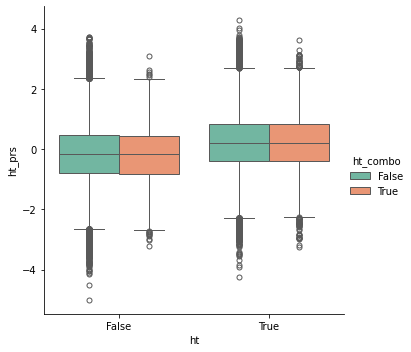

In [102]:
doi = "ht"

g = sns.catplot(
    phenotype_w_prs_icd_df, kind="box", x=f"{doi}", y=f"{doi}_prs", hue=f"{doi}_combo",
    palette="Set2",)
    # fliersize=0, capprops={'color':'none'}, width=0.5,
    #     boxprops={'edgecolor':'k'},  # 'facecolor':'none', 
    #     whiskerprops={'color':'k'}, medianprops={'color':'k'})

# g.set(ylim=(-3, 3))

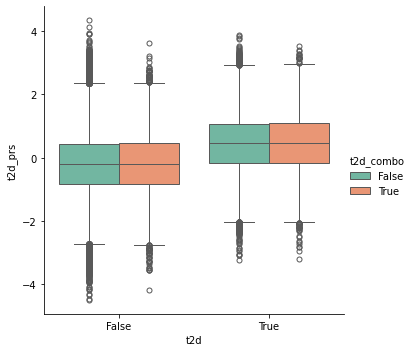

In [101]:
doi = "t2d"

g = sns.catplot(
    phenotype_w_prs_icd_df, kind="box", x=f"{doi}", y=f"{doi}_prs", hue=f"{doi}_combo",
    palette="Set2",)
    # fliersize=0, capprops={'color':'none'}, width=0.5,
    #     boxprops={'edgecolor':'k'},  # 'facecolor':'none', 
    #     whiskerprops={'color':'k'}, medianprops={'color':'k'})

# g.set(ylim=(-3, 3))

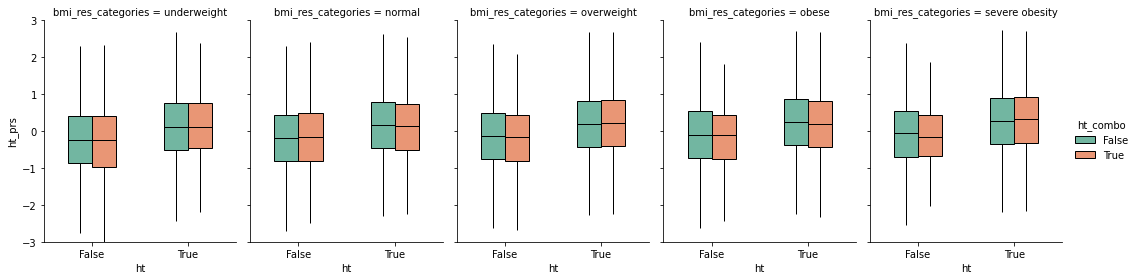

In [93]:
doi = "ht"

g = sns.catplot(
    phenotype_w_prs_icd_df, kind="box", x=f"{doi}", y=f"{doi}_prs", hue=f"{doi}_combo", col="bmi_res_categories", aspect=0.75, height=4,
    col_order=["underweight","normal","overweight","obese","severe obesity"], 
    palette="Set2",
    fliersize=0, capprops={'color':'none'}, width=0.5,
        boxprops={'edgecolor':'k'},  # 'facecolor':'none', 
        whiskerprops={'color':'k'}, medianprops={'color':'k'})

g.set(ylim=(-3, 3))

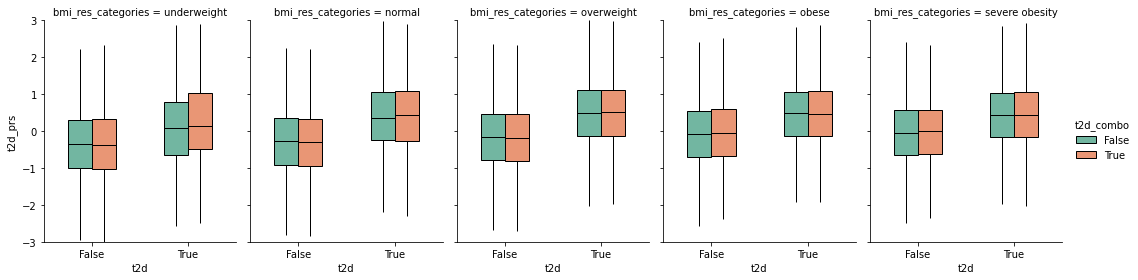

In [94]:
doi = "t2d"

g = sns.catplot(
    phenotype_w_prs_icd_df, kind="box", x=f"{doi}", y=f"{doi}_prs", hue=f"{doi}_combo", col="bmi_res_categories", aspect=0.75, height=4,
    col_order=["underweight","normal","overweight","obese","severe obesity"], 
    palette="Set2",
    fliersize=0, capprops={'color':'none'}, width=0.5,
        boxprops={'edgecolor':'k'},  # 'facecolor':'none', 
        whiskerprops={'color':'k'}, medianprops={'color':'k'})

g.set(ylim=(-3, 3))

In [28]:
phenotype_w_prs_df["obese"] = phenotype_w_prs_df.sample_names.isin(obese_samples)

In [29]:
ht_node = pheno_tree.node_dict[c2nodeid_dict["I10"]]
ht_samples = ht_node.get_samples()

t2d_node = pheno_tree.node_dict[c2nodeid_dict["E11"]]
t2d_samples = t2d_node.get_samples()

In [30]:
phenotype_w_prs_df = phenotype_w_prs_df.loc[phenotype_w_prs_df.sample_names.isin(all_icd_samples)]

In [31]:
phenotype_w_prs_df["ht"] = phenotype_w_prs_df.sample_names.isin(ht_samples)
phenotype_w_prs_df["t2d"] = phenotype_w_prs_df.sample_names.isin(t2d_samples)

In [32]:
ht_combo_samples = set(all_combo_w_icd_df.loc[all_combo_w_icd_df.code=="I10", "combo_samples"].values)
t2d_combo_samples = set(all_combo_w_icd_df.loc[all_combo_w_icd_df.code=="E11", "combo_samples"].values) 

In [33]:
phenotype_w_prs_df["ht_combo"] = phenotype_w_prs_df.sample_names.isin(ht_combo_samples)
phenotype_w_prs_df["t2d_combo"] = phenotype_w_prs_df.sample_names.isin(t2d_combo_samples)

In [47]:
phenotype_w_prs_df["ht_prs_decile"] = pd.qcut(phenotype_w_prs_df.ht_prs, q=10, labels=False)
phenotype_w_prs_df["ht_prs_categories"] = phenotype_w_prs_df.ht_prs_decile.map({
    0: "lowest", 
    1:"middle", 2:"middle", 
    3:"middle", 4:"middle", 5:"middle", 6:"middle", 7:"middle",
    8:"middle", 9:"highest"
    })
phenotype_w_prs_df["t2d_prs_decile"] = pd.qcut(phenotype_w_prs_df.t2d_prs, q=10, labels=False)
phenotype_w_prs_df["t2d_prs_categories"] = phenotype_w_prs_df.t2d_prs_decile.map({
    0: "lowest", 
    1:"middle", 2:"middle", 
    3:"middle", 4:"middle", 5:"middle", 6:"middle", 7:"middle",
    8:"middle", 9:"highest"
    })

In [62]:
def get_table_icd(combo_samples, noncombo_samples, comorbid_samples, field):
    table = [
        [len(combo_samples.intersection(comorbid_samples)), len(combo_samples.difference(comorbid_samples))],
        [len(noncombo_samples.intersection(comorbid_samples)), len(noncombo_samples.difference(comorbid_samples))]
    ]
    df = pd.DataFrame(table, columns=[f"{field}", f"No {field}"], index=["Combo", "Non Combo"])
    return df

def get_odds_ratio(df, var):
    combo_samples = set(df.loc[df[f"{var}_combo"]==True, "sample_names"].values)
    noncombo_samples = set(df.loc[df[f"{var}_combo"]==False, "sample_names"].values)
    comorbid_samples = set(df.loc[df[f"{var}"]==True, "sample_names"].values)
    df = get_table_icd(combo_samples, noncombo_samples, comorbid_samples, var)
    print(df)
    res = fisher_exact(df)
    return pd.Series({"pvalue": res.pvalue, "odds": res.statistic})

In [63]:
doi="ht"
phenotype_w_prs_df.groupby(["ht_prs_categories"]).apply(get_odds_ratio, f"{doi}")

              ht  No ht
Combo       1506    139
Non Combo  17324  19357
             ht  No ht
Combo       629    272
Non Combo  6838  30589
              ht   No ht
Combo       8251    1642
Non Combo  93032  203674


,pvalue,odds
ht_prs_categories,,
highest,3.755047e-312,12.105983
lowest,1.060388e-242,10.344701
middle,0.000000e+00,11.001114


In [59]:
doi="t2d"
phenotype_w_prs_df.groupby(["ht_prs_decile"]).apply(get_odds_ratio, f"{doi}")

,pvalue,odds
ht_prs_decile,,
0,7.976754e-216,7.039110
1,2.993476e-223,6.576917
2,2.315560e-246,6.896764
3,1.280569e-249,6.684931
4,3.826934e-306,7.598295
5,7.477100e-297,7.252779
6,0.000000e+00,7.370000
7,0.000000e+00,7.236683
8,2.237282e-316,6.705659


In [60]:
phenotype_w_prs_df

,sample_names,genetic_sex,bmi_prs,genetic_pca1,genetic_pca2,genetic_pca3,genetic_pca4,genetic_pca5,genetic_pca6,genetic_pca7,...,t2d_prs,obese,ht,t2d,ht_combo,t2d_combo,ht_prs_decile,t2d_prs_decile,ht_prs_categories,t2d_prs_categories
0,1000028,1,-0.652309,-1.049343,-0.035594,-0.318610,1.066207,0.842138,1.140278,-0.434576,...,2.275420,False,False,False,False,False,6,9,middle,highest
1,1000045,0,-1.084330,-0.375479,-0.102603,-0.511934,-0.043436,-0.143338,-0.247138,0.968845,...,0.247464,False,False,False,False,False,0,6,lowest,middle
2,1000171,0,-0.980411,-0.382776,-0.734280,0.182330,0.271249,1.016180,-0.127882,0.524564,...,2.392380,True,False,False,False,False,7,9,middle,highest
3,1000196,0,0.032952,9.739123,-21.189125,-11.847223,-0.065353,0.439113,-1.558717,-0.468649,...,0.496997,False,False,False,False,False,1,7,middle,middle
4,1000222,1,0.092755,0.531430,0.476652,-0.542410,0.154158,0.426149,-1.585834,0.029176,...,0.295108,False,True,False,False,False,1,6,middle,middle
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
427530,6024818,1,-0.416108,0.307354,0.304317,-0.321877,0.620826,0.169777,-0.224238,-0.205999,...,-1.834430,False,False,False,False,False,0,0,lowest,lowest
427531,6024948,1,0.321514,0.166423,0.526967,-0.109158,0.036097,-0.871575,-0.222492,-0.073084,...,2.334780,True,True,True,False,False,9,9,highest,highest
427532,6025016,1,-1.162700,0.985217,-0.361463,0.462544,-1.308939,0.211924,0.167586,1.328446,...,-1.319190,False,False,False,False,False,0,1,lowest,middle
427534,6025181,1,-0.119517,0.053980,-0.853161,-0.321771,-0.530573,-0.333055,-0.319564,0.371106,...,0.171270,False,False,False,False,False,1,6,middle,middle


In [35]:
def conduct_ttest(df, variable="ht_combo", value="ht_prs"):
    no_var = df.loc[df[variable]==False, value]
    var =  df.loc[df[variable]==True, value]
    res = ttest_ind(var, no_var, alternative="less")
    return pd.Series({"p_value": res.pvalue, f"No {variable}": round(no_var.mean(), 3), f"{variable}": round(var.mean(), 3)})

In [36]:
doi = "ht"
phenotype_w_prs_df.groupby(["bmi_res_categories", f"{doi}"]).apply(conduct_ttest, *(f"{doi}_combo", f"{doi}_prs"))

p_value  No ht_combo  ht_combo
bmi_res_categories ht                                    
normal             False  0.526795       -0.190    -0.187
                   True   0.099879        0.160     0.126
obese              False  0.124126       -0.097    -0.178
                   True   0.038732        0.234     0.190
overweight         False  0.036141       -0.141    -0.193
                   True   0.709766        0.203     0.210
severe obesity     False  0.115551       -0.064    -0.162
                   True   0.878971        0.275     0.301
underweight        False  0.205601       -0.230    -0.280
                   True   0.562402        0.129     0.136

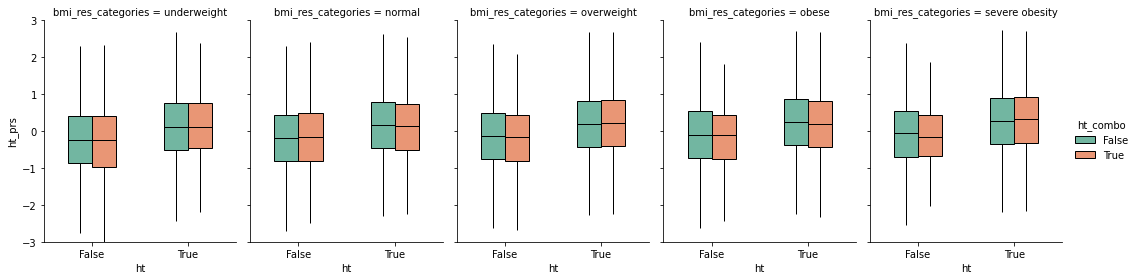

In [37]:
doi = "ht"

g = sns.catplot(
    phenotype_w_prs_df, kind="box", x=f"{doi}", y=f"{doi}_prs", hue=f"{doi}_combo", col="bmi_res_categories", aspect=0.75, height=4,
    col_order=["underweight","normal","overweight","obese","severe obesity"], 
    palette="Set2",
    fliersize=0, capprops={'color':'none'}, width=0.5,
        boxprops={'edgecolor':'k'},  # 'facecolor':'none', 
        whiskerprops={'color':'k'}, medianprops={'color':'k'})

g.set(ylim=(-3, 3))

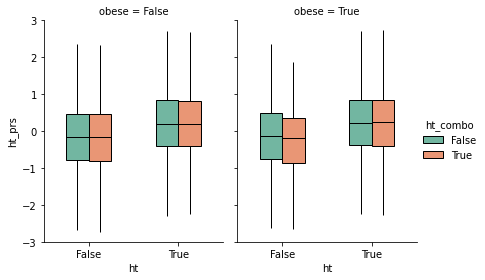

In [38]:
doi = "ht"

g = sns.catplot(
    phenotype_w_prs_df, kind="box", x=f"{doi}", y=f"{doi}_prs", hue=f"{doi}_combo", col="obese", aspect=0.75, height=4,  
    palette="Set2",
    fliersize=0, capprops={'color':'none'}, width=0.5,
        boxprops={'edgecolor':'k'},  # 'facecolor':'none', 
        whiskerprops={'color':'k'}, medianprops={'color':'k'})

g.set(ylim=(-3, 3))

In [39]:
doi = "t2d"
phenotype_w_prs_df.groupby(["bmi_res_categories", f"{doi}"]).apply(conduct_ttest, *(f"{doi}_combo", f"{doi}_prs"))

p_value  No t2d_combo  t2d_combo
bmi_res_categories t2d                                     
normal             False  0.112022        -0.283     -0.304
                   True   0.450032         0.402      0.396
obese              False  0.952407        -0.074     -0.033
                   True   0.330869         0.482      0.470
overweight         False  0.189272        -0.166     -0.176
                   True   0.614719         0.486      0.491
severe obesity     False  0.927118        -0.044     -0.007
                   True   0.867807         0.430      0.453
underweight        False  0.610947        -0.354     -0.347
                   True   0.892695         0.096      0.204

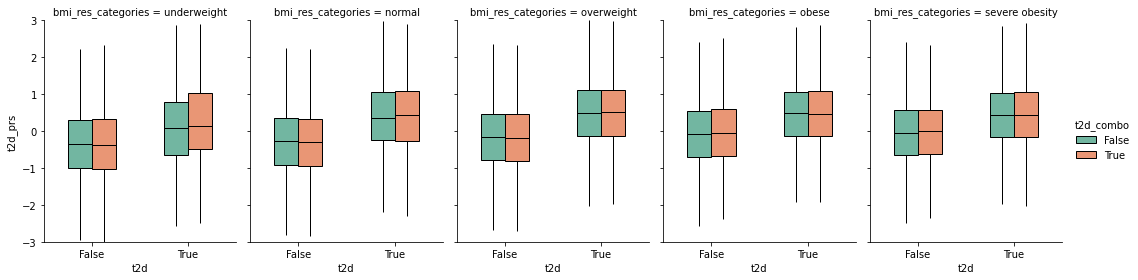

In [40]:
doi = "t2d"

g = sns.catplot(
    phenotype_w_prs_df, kind="box", x=f"{doi}", y=f"{doi}_prs", hue=f"{doi}_combo", col="bmi_res_categories", aspect=0.75, height=4,
    col_order=["underweight","normal","overweight","obese","severe obesity"], 
    palette="Set2",
    fliersize=0, capprops={'color':'none'}, width=0.5,
        boxprops={'edgecolor':'k'},  # 'facecolor':'none', 
        whiskerprops={'color':'k'}, medianprops={'color':'k'})

g.set(ylim=(-3, 3))

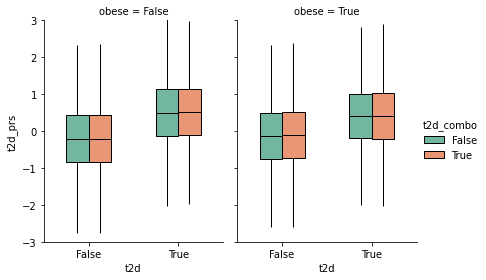

In [41]:
doi = "t2d"

g = sns.catplot(
    phenotype_w_prs_df, kind="box", x=f"{doi}", y=f"{doi}_prs", hue=f"{doi}_combo", col="obese", aspect=0.75, height=4,  
    palette="Set2",
    fliersize=0, capprops={'color':'none'}, width=0.5,
        boxprops={'edgecolor':'k'},  # 'facecolor':'none', 
        whiskerprops={'color':'k'}, medianprops={'color':'k'})

g.set(ylim=(-3, 3))

In [178]:
phenotype_w_prs_df.loc[:, ["bmi_prs", "ht_prs", "t2d_prs"]].corr()

,bmi_prs,ht_prs,t2d_prs
bmi_prs,1.000000,0.139386,0.230127
ht_prs,0.139386,1.000000,0.201223
t2d_prs,0.230127,0.201223,1.000000
